# Dynamic Time Warping for Sequence-to-Sequence mapping of vector data


### DP Formulas

This DTW will find the alignment {(X_i(s),Y_j(s)), s=1:N} that minimizes:   
>    Sum_s \[ m_t \*||X_i(s)- Y_j(s)||^p + a_t \]  

with constraints   
>    i(1)=j(1)=1  ,  i(N)=Nx,j(N)=Ny   i(s)>=i(s-1),j(s)>=j(s-1),   
>    further subject to transition constraints (s-1)=>(s) and m_t and a_t transition costs

#### Data Structures

Feature Sequences are represented as

X(Nx,D), Y(Ny,D), ...  i.e. numpy arrays of size (number of frames, number of features)   

A 1D array of length N is cast to a a 2D array of size (N,1)
Therefore a single feature of width D must be explicitly passed as a (1,D) 2D array

In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## Example 1:  1D feature vectors

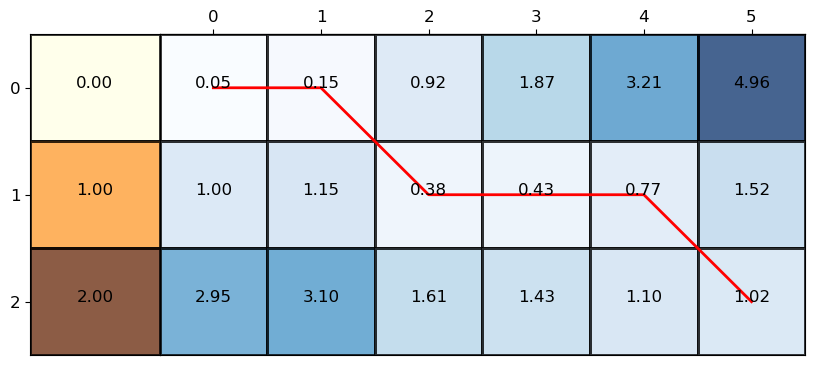

In [2]:
# plotting cummulative distance matrix and only y-features
x1d = np.array([.05, -.1, 0.77, .95, 1.335, 1.75])
y1d = np.array([0.,1.,2.])
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='LEV',result='details')
fig = dtw.plot_trellis(x=None,y=y1d,xy_mat=cd_matrix.T,xy_line=trace,xy_annot=True,ftr_annot=True)
fig

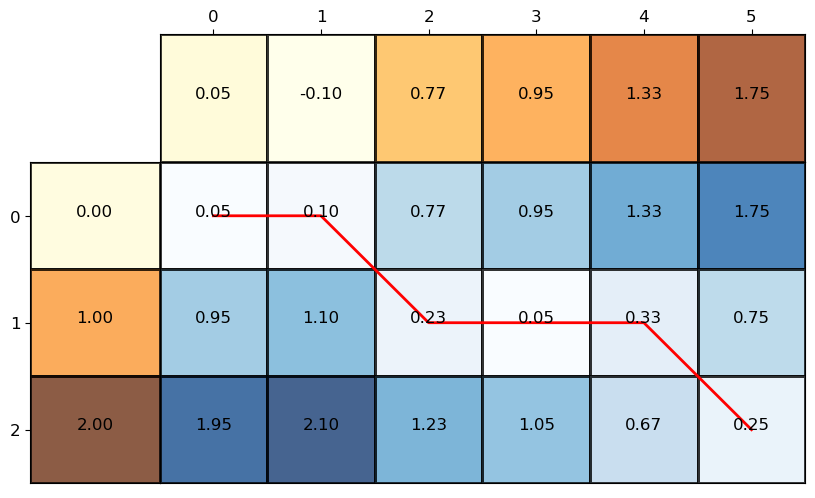

In [3]:
# plotting local distance matrix and both x- and y-features
fig = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=ld_matrix.T,xy_line=trace,xy_annot=True,ftr_annot=True)
fig

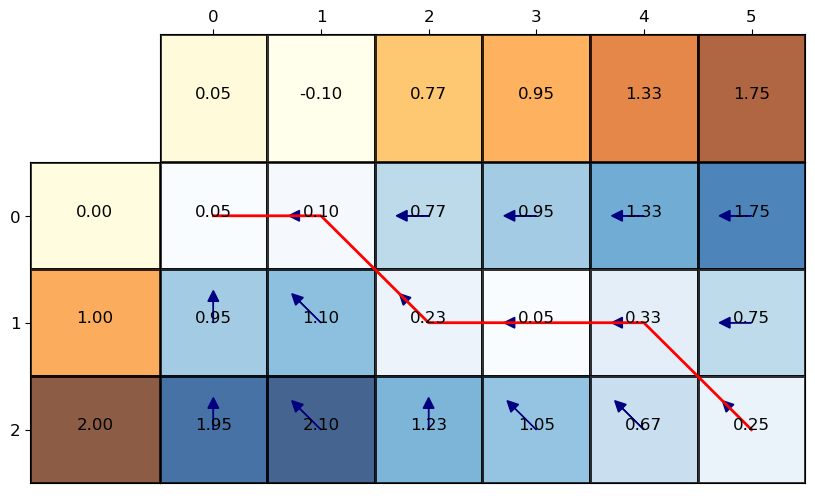

In [4]:
# a standalone routine to add backpointers 
# is sometimes handy, but can be done in main routine as well
def add_trellis_bptrs(fig,bptrs):
    Nx = bptrs.shape[0]
    Ny = bptrs.shape[1]
    for i in range(Nx):
        for j in range(Ny):
            if (i==0) and (j==0): continue
            ii,jj = bptrs[i,j]
            fig.axes[3].arrow(i,j,0.2*(ii-i),0.2*(jj-j),color='navy',linewidth=1,head_width=.1,head_length=.1)   
add_trellis_bptrs(fig,bptrs)
fig

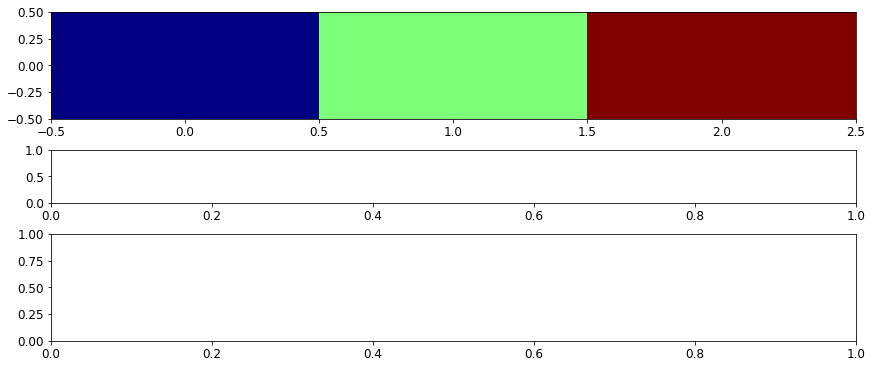

In [6]:

fig = Spd.SpchFig(row_heights=[2. , 1., 2.], figsize=(12,5) )
fig.add_img_plot(y1d.reshape(1,-1),iax=0) 
fig

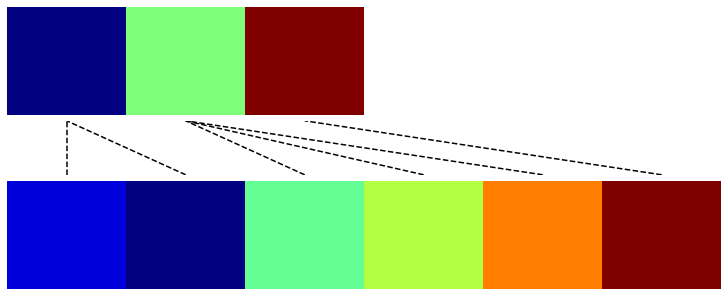

In [7]:
fig = dtw.plot_align(x1d,y1d,xy_trace=trace,down_sample=1)
fig

## Multi-dimensional features with annotations

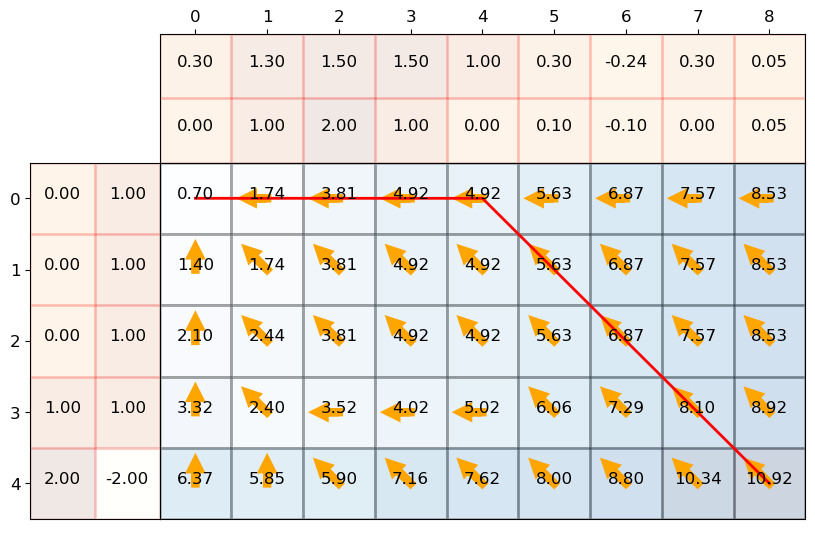

In [5]:
x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2.],[1.,1.,1.,1.,-2.]]).T
x_ftrs=x2d
y_ftrs=y2d
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='LEV',result='details')
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix.T,xy_line=trace,xy_annot=True,ftr_annot=True,
            xy_args={'alpha':.2,'edgecolor':'k'}, 
            bptrs=bptrs,bptr_args={'color':'orange','linewidth':6},
            ftr_args={'cmap':'YlOrBr','edgecolor':'r','alpha':.1})
#bptrs=bptrs,
#add_trellis_bptrs(fig,bptrs)
fig

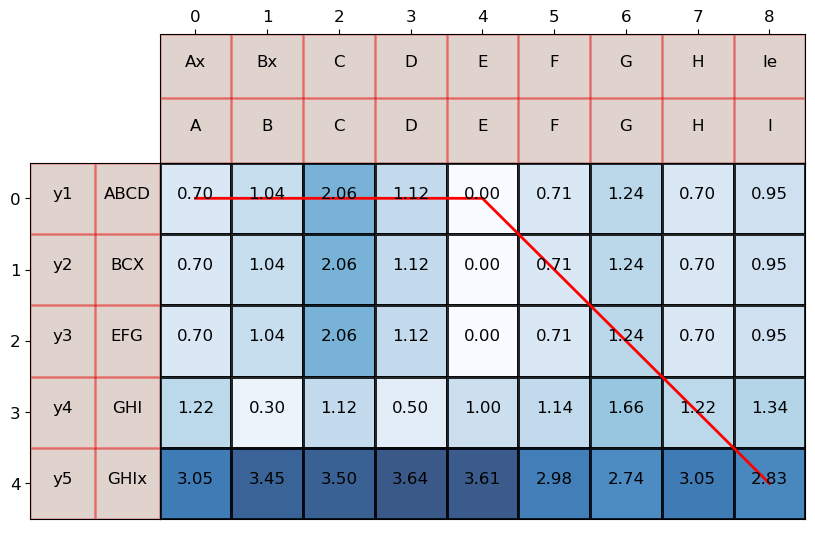

In [6]:
# same trellis plot , but with string features
x_annot = np.array([ ["A","B","C","D","E","F","G","H","I"],["Ax","Bx","C","D","E","F","G","H","Ie"] ]).T
y_annot = np.array([ ["y1","y2","y3","y4","y5"], ["ABCD", "BCX","EFG","GHI","GHIx"] ]).T

x_ftrs = x_annot
y_ftrs = y_annot
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix.T,xy_line=trace,xy_annot=True,ftr_annot=True,\
              xy_args={'alpha':.8,'edgecolor':'k'},ftr_args={'cmap':'YlOrBr','edgecolor':'r','alpha':.2})
fig

In [24]:
def pcolormesh_data(data,x=None,y=None,x0=0,y0=0,dx=1,dy=1,ax=None,**kwargs):
    '''
    pcolormesh on a rectangular data grid
    with shading flat and x,y as pixel centers
    
    '''
    Ny,Nx = data.shape
    if x is None:
        if x0 is None: x0 = 0
        x = np.arange(Nx)*dx + x0
    elif Nx>1: dx = x[1]-x[0]
    if y is None:
        if y0 is None: y0 = 0
        y = np.arange(Ny)*dy + y0
    elif Ny>1: dy = y[1]-y[0]

    # convert pixel centers to edge points
    xi = np.arange(Nx+1)-.5*dx
    yi = np.arange(Ny+1)-.5*dy
    ax.pcolormesh(xi,yi,data,shading='flat',**kwargs)

In [25]:
x = np.array([1,2,4])
x - .5

array([0.5, 1.5, 3.5])

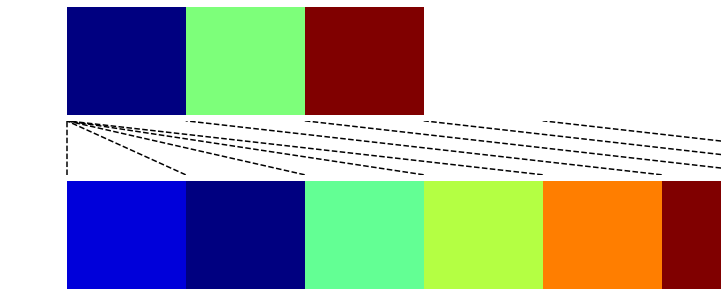

In [13]:
fig = dtw.plot_align(x1d,y1d,xy_trace=trace,down_sample=1)
fig

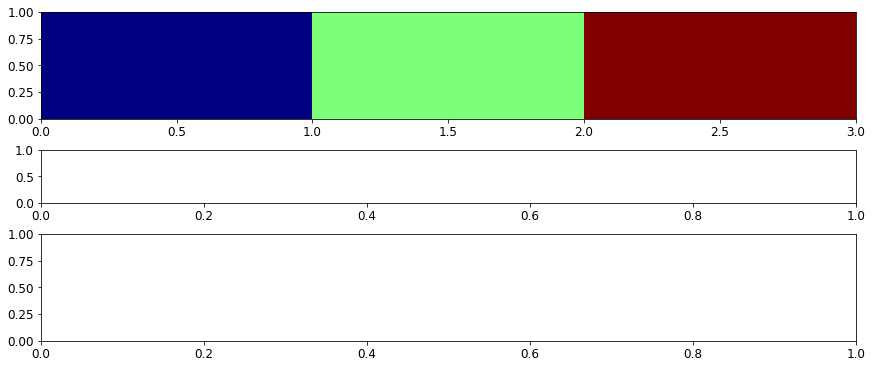

In [10]:
y = y1d.reshape(-1,1).T
f,ax = plt.subplots()
#pcolormesh_data(y,ax=ax)
fig = Spd.SpchFig(row_heights=[2. , 1., 2.], figsize=(12,5) )

fig.add_img_plot(y,iax=0) 
fig
#y, y.shape

In [ ]:
# view the alignment plotted on top of cummulative distance marix
f,ax = plt.subplots(3)
plt.subplots_adjust(hspace=.3)
sns.heatmap(ld.T,ax=ax[0],annot=True,fmt='.3g',cbar=False).set(title='local distance matrix')
sns.heatmap(cd.T,ax=ax[1],annot=True,fmt='.3g',cbar=False).set(title='cummulative distance matrix')
sns.heatmap(cd.T,ax=ax[2],cbar=False).set(title='backtracking and backtrace')
for i in range(len(x)):
    for j in range(len(y)):
        if (i==0) and (j==0): continue
        ii,jj = bptrs[i,j]
        plt.arrow(i+.5,j+.5,0.2*(ii-i),0.2*(jj-j),color='lime',linewidth=4,head_width=.1,head_length=.1)
sns.lineplot(x=al[:,0]+0.5,y=al[:,1]+0.5,ax=ax[2],color='r',lw=2)     

In [ ]:
x_wp, y_wp = warp(x,y)
[ (x,y) for (x,y) in zip(x_wp,y_wp) ]

In [ ]:
f,ax = plt.subplots(2)
sns.heatmap(x_wp.T,ax=ax[0])
sns.heatmap(y_wp.T,ax=ax[1])

# Now with speech data

In [ ]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/audio/'
# sa1: she had your dark suit in greasy washwater all year
# sa2: don't ask me to carry an oily rag like that
# note there are some word segmentation errors in sa1, phn segmentations are OK

xname = dir+'train/dr1/fcjf0/sa2'
yname = dir+'train/dr1/fdaw0/sa2'

xwavdata, sr = Spch.load(xname+".wav")
ywavdata, sr = Spch.load(yname+".wav")

xsegdata = Spch.read_seg_file(xname+ ".wrd",dt=1/sr,fmt='float32')
ysegdata = Spch.read_seg_file(yname+ ".wrd",dt=1/sr,fmt='float32')
# compute a spectrogram with default parameters

n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspgdata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=None)
xmeldata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,xnfr)=xspgdata.shape
d_freq = sr/(2.*(nparam-1))
yspgdata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=None)
ymeldata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=24)

In [ ]:

fig = Spd.PlotSpgFtrs(wavdata=xwavdata,spgdata=xspgdata,#segwav=xsegdata,
                      img_ftrs=[xmeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
#
fig = Spd.PlotSpgFtrs(wavdata=ywavdata,spgdata=yspgdata, #segwav=ysegdata,
                  img_ftrs=[ymeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)

In [ ]:
fig.axes[2].plot()

In [ ]:
plt.plot(xspgdata[250:257,:].T)

In [ ]:
x_ftrs = xmeldata
y_ftrs = ymeldata
cost,trace,ld_matrix,cd_matrix,_ = dtw(x_ftrs.T,y_ftrs.T,trans='LEV',result='details')
#fig = plot_xy(xy_mat=ld_matrix.T,xy_line=trace,y=yspgdata.T,x=xspgdata.T,fig_width=8,ftr_args={'cmap':'jet'})
fig = plot_xy(xy_mat=ld_matrix.T,xy_line=None,y=yspgdata[0:255,:].T,x=xspgdata[0:255,:].T,fig_width=8,ftr_args={'cmap':'Greys','norm':None})
#fig = plot_xy(xy_mat=ld_matrix.T,xy_line=trace,y=ymeldata[0:5,:].T,x=xmeldata[0:5,:].T,fig_width=8,ftr_args={'cmap':'jet'})
fig

In [ ]:
cd_matrix.shape, np.max(ld_matrix), np.max(cd_matrix)

In [ ]:
np.min([np.inf,37934])

In [ ]:
ld_matrix[0:2,0:4], cd_matrix[0:2,0:4]

In [ ]:
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
cost,trace,ld_matrix,cd_matrix,_ = dtw(x_ftrs,y_ftrs,trans='ITA',result='details')
fig = dp_plot_1d(x_ftrs=x_ftrs,y_ftrs=y_ftrs,xy_trace=trace,down_sample=3)
fig

In [ ]:
# plotting alignments via superposition 
def plot_align_1d(x_ftrs,y_ftrs,*,x_wav=None,y_wav=None,x_seg=None,y_seg=None,shift=.01,sr=16000,xy_trace=None,down_sample=1):
    
    if x_wav is None or y_wav is None:
        WavPlot = False
        row_heights = [1.,.5,1.]
        figsize = (12,5)
        ax_x = 0
        ax_tr = 1
        ax_y = 2
    else:
        row_heights = [1., 1., .5, 1., 1.]
        WavPlot = True
        figsize = (12,7)
        ax_xwav = 0
        ax_x = 1
        ax_tr =2
        ax_y = 3
        ax_ywav = 4
        
    xrange = np.array([-.5,max(x_ftrs.shape[0],y_ftrs.shape[0])-.5])*shift
    fig = Spd.SpchFig(row_heights=row_heights, figsize=figsize )
    
    if WavPlot:
        fig.add_line_plot(ywavdata,iax=ax_ywav,dx=1/sr)
        fig.add_line_plot(xwavdata,iax=ax_xwav,dx=1/sr)
        if x_seg is not None:
            fig.add_seg_plot(x_seg,iax=ax_xwav,ypos=0.8)
        if y_seg is not None:
            fig.add_seg_plot(y_seg,iax=ax_ywav,ypos=0.2)            
        
    fig.add_img_plot(y_ftrs.T,iax=ax_y,dx=shift)   
    fig.add_img_plot(x_ftrs.T,iax=ax_x,dx=shift)
    for ax in fig.axes:
        ax.set_xlim(xrange)
        ax.axis('off')

    fig.axes[ax_tr].set_ylim([-1.,1.])
    ax = fig.axes[ax_tr]
    for i in range(0,len(xy_trace),down_sample) :
        ax.plot(xy_trace[i]*shift,[1,-1],linestyle='dashed',color='k')        
        
    return(fig)

In [ ]:
fig = plot_align_1d(x_ftrs,y_ftrs,x_wav=xwavdata,y_wav=ywavdata,x_seg=xsegdata,y_seg=ysegdata,xy_trace=trace,shift=shift,sr=sr,down_sample=3)
fig

In [ ]:
xsegdata

In [ ]:
fig.add_seg_plot(xsegdata,iax=0,ypos=0.8)
fig.add_seg_plot(ysegdata,iax=4,ypos=0.2)
fig

In [ ]:
def plot_xy_img(xy_mat=None,xy_line=None,x=None,y=None,x_annot=None,aspect='equal',xy_cmap='Blues',ftr_cmap='jet',
            ftr_fmt='img',
            width_ratios=None,height_ratios=None,ftr_scale=None,fig_width=10.,annot=False,**kwargs):
    '''
    ftr_scale defines fixed aspect ratio between ftr plots and matrix plot
    '''
    
    ny,nx = xy_mat.shape
    n = max(nx,ny)
    if (n > 50) & annot :
        print("WARNING(plot_xy): Annotation is turned off for dimensions > 50 !")
        annot = False
        
    if x is not None: _,dx = x.shape
    else: dx = 0
    if y is not None: _,dy = y.shape
    else: dy = 0    

    d = max(dx,dy)
    if ftr_scale is not None:

        if dx != 0 : dx = ftr_scale*n
        if dy != 0 : dy = ftr_scale*n
        
    if width_ratios is None:
        width_ratios = [ float(dy)/(nx+dy), float(nx)/(nx+dy) ]
    if height_ratios is None:
        height_ratios = [ float(dx)/(ny+dx), float(ny)/(ny+dx) ]
    fig_aspect = float(ny+dx)/float(nx+dy)
    fig = plt.figure(figsize=(fig_width,fig_width*fig_aspect) )
    gs = fig.add_gridspec(nrows=2,ncols=2,
                          width_ratios=width_ratios,
                          height_ratios=height_ratios ,
                          hspace=0., wspace=0. ) 
    ax_xy = fig.add_subplot(gs[1,1])
    ax_x = fig.add_subplot(gs[0,1])
    ax_y = fig.add_subplot(gs[1,0])


    
    for ax in [ax_xy, ax_x, ax_y]:
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    ax_x.xaxis.set_visible(True)
    ax_x.xaxis.set_ticks_position('top')
    ax_y.yaxis.set_visible(True)
    ax_y.yaxis.set_ticks_position('left')
    
    if annot == True:  # use seaborn if annotations are requested
        sns.heatmap(xy_mat,ax=ax_xy,annot=True,cmap=xy_cmap,cbar=False)        
        if xy_line is not None:
            sns.lineplot(x=xy_line[:,0]+0.5,y=xy_line[:,1]+0.5,ax=ax_xy,color='r',lw=2) 
    else:
        ax_xy.imshow(xy_mat,cmap=xy_cmap,aspect='auto')
        if xy_line is not None:
            ax_xy.plot(xy_line[:,0],xy_line[:,1],lw=3,color='r')
    #ax_x.sharex(ax_xy)
    #ax_y.sharey(ax_xy)
    if ftr_fmt == 'img':
        if x is not None: ax_x.imshow(x.T,cmap=ftr_cmap,aspect='auto',origin='lower')
        if y is not None: ax_y.imshow(y,cmap=ftr_cmap,aspect='auto')
    elif ftr_fmt == 'txt':
        if x is not None:
             
            for i in range(nx):
                for j in range(d):
                    ax_x.text(i, j,x_annot[j][i] ) # bbox=dict(fill=True, color='green', edgecolor='red', linewidth=2))
    plt.close()
    return fig

In [ ]:
# plots spectrograms in top and left positions

def dp_plot(x_ftrs=None,y_ftrs=None,xy_mat=None,xy_trace=None,aspect=None,xy_cmap='Blues',
            ftr_plot='img',ftr_pos='bottom_left',edges=True,**kwargs):
    
    ## needed as long as pyspch works with (spg)data as in librosa 
    if x_ftrs is not None: x_ftrs = x_ftrs.T
    # if y_ftrs is not None: y_ftrs = y_ftrs.T
    ###
    
    # determine aspect ratio for matrix plot  (this is an approximate solution, not taking into account plot spacings)
    try:
        a = xy_mat.shape[1]/xy_mat.shape[0]
    except:
        a = 1.0
    a_fig = (1.+3.*a)/4. 
    if ftr_pos == 'top_right':
        fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[3.*a,1.],figsize=(10,10*a_fig),**kwargs)
        fig.axes[1].set_visible(False)
        iax_x = [0,0]
        iax_y = [1,1]
        iax_mat = [1,0]
        invert_y = True
        invert_x = False
    if ftr_pos == 'top_left':
        fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[1.,3.*a],figsize=(10,10*a_fig),**kwargs)
        fig.axes[0].set_visible(False)
        iax_x = [0,1]
        iax_y = [1,0]
        iax_mat = [1,1]
        invert_y = True
        invert_x = False
    elif ftr_pos == 'bottom_left':
        fig = Spd.SpchFig(row_heights=[3.,1.], col_widths=[1.,3.*a],figsize=(10,10*a_fig))
        fig.axes[2].set_visible(False)
        iax_x = [1,1]
        iax_y = [0,0]
        iax_mat = [0,1]
        invert_y = False
        invert_x = True
    
    if (xy_mat.shape[0] > 50): edges = False
    edgecolors='k' if edges  else None

    ax = fig.get_axis(iax_mat)
    if invert_y: ax.invert_yaxis()
    if xy_mat is not None:
        fig.add_img_plot(xy_mat.T,iax=iax_mat,edgecolors=edgecolors,cmap=xy_cmap)
    if xy_trace is not None:
        fig.add_line_plot(x=xy_trace[:,0],y=xy_trace[:,1],iax=iax_mat,xrange=None,lw=3,color='r',grid=False)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    if x_ftrs is not None:
        ax = fig.get_axis(iax_x)
        if ftr_plot == 'img':
            fig.add_img_plot(x_ftrs,iax=iax_x,edgecolors=edgecolors)
            if aspect is not None: fig.gca().set_aspect('equal')
        elif ftr_plot == 'line':
            fig.add_line_plot(x_ftrs,iax=iax_x)
            ax.set_xlim(xlim)

    if y_ftrs is not None:   
        ax = fig.get_axis(iax_y)
        if invert_y: ax.invert_yaxis()
        if invert_x: ax.invert_xaxis()
        
        if ftr_plot == 'img':
            fig.add_img_plot(y_ftrs,iax=iax_y,edgecolors=edgecolors)
            if aspect is not None: fig.gca().set_aspect('equal')
        elif ftr_plot == 'line':
            fig.add_line_plot(y_ftrs.T,iax=iax_y,invert_xy=True)
            ax.set_ylim(ylim)
            

        
    return(fig)

In [ ]:
# plots spectrograms in top and right positions
def dp_plot_r(x_ftrs=None,y_ftrs=None,xy_mat=None,xy_trace=None,ftr_plot='img'):
    
    try:
        a = xy_mat.shape[1]/xy_mat.shape[0]
    except:
        a = 1.0
    a_fig = (1.+3.*a)/4. 
    
    fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[3.*a,1],figsize=(10,10*a_fig))
    fig.axes[1].set_visible(False)
    
    if x_ftrs is not None:
        if ftr_plot == 'img':
            fig.add_img_plot(x_ftrs.T,iax=[0,0])
        elif ftr_plot == 'line':
            fig.add_line_plot(x_ftrs.T,iax=[0,0])
            
    if y_ftrs is not None:   
        ax = fig.get_axis([1,1])

        if ftr_plot == 'img':
            fig.add_img_plot(y_ftrs,iax=[1,1])
            ax.invert_yaxis()
            #ax.invert_xaxis()
            #ax.imshow(y_ftrs)
        elif ftr_plot == 'line':
            #n = y_ftrs.shape[1]
            #print(n)
            #ax.plot(y_ftrs,np.arange(n).reshape(1,-1))
            fig.add_line_plot(y_ftrs.T,iax=[1,1],invert_xy=True)
            fig.axes[1]
            
    ax = fig.get_axis([1,0])
    ax.invert_yaxis()
    if xy_mat is not None:
        fig.add_img_plot(xy_mat.T,iax=[1,0])
        #ax.imshow(xy_mat.T,cmap='jet',aspect='auto')
    if xy_trace is not None:
        fig.add_line_plot(x=xy_trace[:,0],y=xy_trace[:,1],iax=[1,0],xrange=None,lw=5,color='r',grid=False)
        
    return(fig)

